In [1]:
import pandas as pd

In [2]:
def load_ff3(val_start_date=None, val_end_date=None):
    ff3 = pd.read_csv("ff3_daily.csv")

    if val_start_date is not None:
        val_start_idx = ff3[ff3['date'] >= int(val_start_date)].index[0]
        
    if val_end_date is not None:
        val_end_idx = ff3[ff3['date'] > int(val_end_date)].index[0]
    
    if val_start_date is not None and val_end_date is not None:
        ff3 = ff3.iloc[val_start_idx:val_end_idx]
    elif val_start_date is not None:
        ff3 = ff3.iloc[val_start_idx:]
    elif val_end_date is not None:
        ff3 = ff3.iloc[:val_end_idx]
    

    ff3 = ff3.reset_index(drop=True)
    ff3.index = ff3["date"]
    ff3 = ff3.drop(columns=["date"])

    return ff3

def load_china(val_start_date=None, val_end_date=None):
    china = pd.read_csv("china_daily.csv")

    if val_start_date is not None:
        val_start_idx = china[china['date'] >= int(val_start_date)].index[0]
        
    if val_end_date is not None:
        val_end_idx = china[china['date'] >= int(val_end_date)].index[0]
    
    if val_start_date is not None and val_end_date is not None:
        china = china.iloc[val_start_idx:val_end_idx]
    elif val_start_date is not None:
        china = china.iloc[val_start_idx:]
    elif val_end_date is not None:
        china = china.iloc[:val_end_idx]
    

    china = china.reset_index(drop=True)
    china.index = china["date"]
    china = china.drop(columns=["date"])

    return china

In [3]:
ff3 = load_ff3("20000104", "20211231")
ff3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5535 entries, 20000104 to 20211231
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  5535 non-null   float64
 1   SMB     5535 non-null   float64
 2   HML     5535 non-null   float64
 3   RF      5535 non-null   float64
dtypes: float64(4)
memory usage: 216.2 KB


In [4]:
us_mkt_ret_vec = ff3["Mkt-RF"] + ff3["RF"]
us_mkt_ret_vec.head()

date
20000104   -4.039
20000105   -0.069
20000106   -0.709
20000107    3.231
20000110    1.781
dtype: float64

In [5]:
import matplotlib.pyplot as plt
import os

In [6]:
def show_cumulative_returns(
    strat_ret_vec,
    mkt_ret_vec,
    ret_port_style,
    plot_lines=None,
    strategy_name="Strategy",
    market_name="US Market",
    log_scale=False,
    show_plots=False,
    save=False,
):
    cum_strat_rets = (1 + strat_ret_vec / 100).cumprod()
    cum_mkt_rets = (1 + mkt_ret_vec / 100).cumprod()

    cum_mkt_rets.index = pd.to_datetime(cum_mkt_rets.index, format="%Y%m%d")
    cum_mkt_rets_monthly = cum_mkt_rets.resample("W").last()

    cum_strat_rets.index = pd.to_datetime(cum_strat_rets.index, format="%Y%m%d")
    cum_strat_rets_monthly = cum_strat_rets.resample("W").last()

    if show_plots:
        # fig, axs = plt.subplots(2, 1, figsize=(12, 6))
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        # Plot the cumulative returns
        axs.plot(cum_strat_rets, label=strategy_name)
        axs.plot(cum_mkt_rets, label=market_name)
        if plot_lines:
            for line in plot_lines:
                plot_line = pd.to_datetime(line, format="%Y%m%d")
                plt.axvline(x=plot_line, color='r', linestyle='--')

        if log_scale:
            axs.yscale("log")
        axs.set_xlabel("Year")
        axs.set_ylabel("Cumulative Return")
        axs.legend()
        axs.set_title(f"Returns Portfolio Style: {ret_port_style}")

        strat_ret_vec_monthly = strat_ret_vec.copy()
        strat_ret_vec_monthly.index = pd.to_datetime(strat_ret_vec_monthly.index, format="%Y%m%d")
        strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
        
        mkt_ret_vec_monthly = mkt_ret_vec.copy()
        mkt_ret_vec_monthly.index = pd.to_datetime(mkt_ret_vec_monthly.index, format="%Y%m%d")
        mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
        
        # x = np.arange(len(strat_ret_vec_monthly.index))
        
        # num_ticks = 7
        # tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
        # tick_labels = strat_ret_vec_monthly.index[tick_positions].strftime('%Y')

        # barwidth = 0.2
        
        # axs[1].bar(x - barwidth/2, strat_ret_vec_monthly.values, label=strategy_name, width=barwidth )
        # axs[1].bar(x + barwidth/2, mkt_ret_vec_monthly.values, label="Market", width=barwidth)
        # axs[1].set_xlabel("Year")
        # axs[1].set_ylabel("Yearly Return")
        # axs[1].legend()
        # axs[1].set_title(f"Returns Portfolio Style: {ret_port_style}")
        # axs[1].grid(axis='y', linestyle='--', alpha=0.7)
        
        # axs[1].set_xticks(tick_positions)
        # axs[1].set_xticklabels(tick_labels, rotation=90)

        plt.title(f"Returns Portfolio Style: {ret_port_style}")
        
        # Save plot
        if save:
            name = strategy_name.replace("models", "")
            os.makedirs(f"results/{name}/{ret_port_style}", exist_ok=True)
            plt.savefig(f"results/{name}/{ret_port_style}/cumulative_returns.png")

        plt.show()

    # Save the plot
    if save:
        name = strategy_name.replace("models", "")
        os.makedirs(f"results/{name}/{ret_port_style}", exist_ok=True)

        # save cum_strat_rets in csv
        cum_strat_rets.to_frame().to_csv(
            f"results/{name}/{ret_port_style}/cumulative_returns.csv"
        )

        # save strat_ret_vecs in csv
        strat_ret_vec.to_frame().to_csv(
            f"results/{name}/{ret_port_style}/strat_ret_vec.csv"
        )

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm


def get_return_z_score(ret_series, val_date):
    """
    Given a cumulative return series and a specific date, this function:
    1. Computes the daily returns from the cumulative returns.
    2. Extracts the last 7 daily returns prior to the given date.
    3. Computes the z-score and p-value of the return on the val_date 
       relative to those previous 7 returns.

    Parameters
    ----------
    cum_ret_series : pd.Series
        A pandas series of cumulative returns indexed by dates.
        Index should be datetime or a format convertible to datetime.
    val_date : str or pd.Timestamp
        The date for which we want to compute the z-score and p-value. 
        Should match the format of the series index.

    Returns
    -------
    z_score : float
        The z-score of the val_date's return compared to the previous 7 returns.
    p_value : float
        The two-tailed p-value corresponding to the z-score.
    """

    cum_ret_series = (1 + ret_series / 100).cumprod()

    # Ensure the index is datetime
    if not pd.api.types.is_datetime64_any_dtype(cum_ret_series.index):
        cum_ret_series.index = pd.to_datetime(cum_ret_series.index, format="%Y%m%d", errors='coerce')
    
    # Compute daily returns from cumulative returns
    daily_returns = cum_ret_series.pct_change().dropna()  # Daily returns as decimal (not percent)

    if val_date not in daily_returns.index:
        val_idx = daily_returns.index.searchsorted(val_date)
    else:
        val_idx = daily_returns.index.get_loc(val_date) + 1

    print('val_idx:', val_idx, daily_returns.iloc[val_idx], daily_returns.index[val_idx])
    
    # Find the position of val_date in the daily_returns
    # first_idx_le_date = daily_returns.index[daily_returns.index <= val_date][0]
    # val_idx = daily_returns.index.get_loc(val_date)
    if val_idx < 7:
        raise ValueError("Not enough historical data (less than 7 days before val_date).")
    
    # Get the last 7 returns before val_date
    last_7_returns = np.abs(daily_returns.iloc[val_idx-7:val_idx])

    # Current day's return
    current_return = np.mean(np.abs(daily_returns.iloc[val_idx]))

    # Compute mean and std of last 7 returns
    mean_7 = last_7_returns.mean()
    std_7 = last_7_returns.std()

    if std_7 == 0:
        # If there's no variation in the last 7 days, z-score is not defined.
        # You can choose how to handle this case.
        raise ValueError("Standard deviation of the last 7 returns is zero, cannot compute z-score.")

    # Compute z-score
    z_score = (current_return - mean_7) / std_7

    # Compute two-tailed p-value from z-score
    p_value = 2 * (1 - norm.cdf(abs(z_score)))

    return z_score, p_value


# Example usage within your code (assume cum_strat_rets or cum_mkt_rets is defined):
# Assuming cum_strat_rets is your cumulative returns series
# val_date = "2015-03-12"  # Make sure your date format matches your series index
# z, p = get_return_z_score(cum_strat_rets, val_date)
# print("Z-Score:", z)
# print("p-value:", p)

In [245]:
def plotting(start_date, val_date, plot_lines=None):
    ff3 = load_ff3(start_date, val_date)
    china = load_china(start_date, val_date)
    us_mkt_ret_vec = ff3["Mkt-RF"] + ff3["RF"]
    china_mkt_ret_vec = china["mktrf"] + china["rf_dly"]

    show_cumulative_returns(china_mkt_ret_vec, us_mkt_ret_vec, ret_port_style="Chinese Market", plot_lines=plot_lines, strategy_name="China Market", log_scale=False, show_plots=True, save=True)
    
    for line in plot_lines:
        zscore, p_val = get_return_z_score(china_mkt_ret_vec, line)
        print(f"For the event on: {pd.to_datetime(line).date()}, Z-Score: {zscore} and p-value: {p_val}")

/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_48340/1093611962.py:41: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
/var/folders/zb/fkkd7bp953d7h5656xfypnd40000gn/T/ipykernel_48340/1093611962.py:45: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)


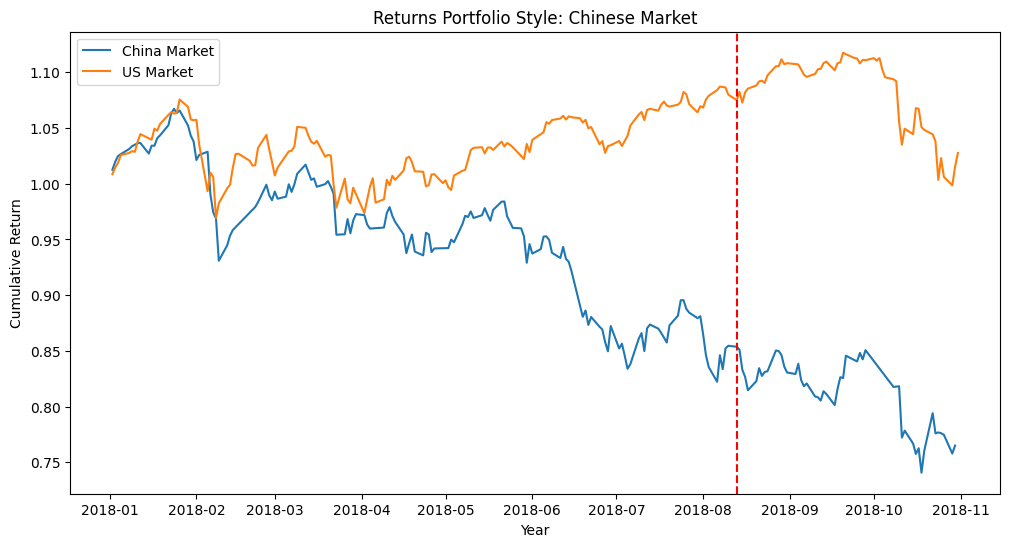

val_idx: 149 -0.0030449999999999644 2018-08-14 00:00:00
For the event on: 2018-08-13, Z-Score: -1.70564772311122 and p-value: 0.08807368831221751


In [246]:
plotting("20180101", "20181031", ['20180813'])

In [ ]:
# Idea: get the 7 returns (need to convert from last 7 cumulative returns) and
# get their mean and standard deviation. Then get the Z-Score and p-value of the return that
# happens on the day of the passed in date relative to the last 7 returns.